In [1]:
import geopandas as gpd 
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from datetime import datetime
import metloom
import numpy as np
from metloom.pointdata import SnotelPointData
from metloom.pointdata import CDECPointData
from metloom.pointdata import USGSPointData

homedir = '/users/cowherd/Documents/wy2023/'

In [3]:
gaged_basins = gpd.read_file(homedir + 'data/gaged_basins_gdf.gdf')
ca_eco = gpd.read_file(homedir + 'data/ca_eco_l3.gdf')
sn = ca_eco[4:5]
sn_rp = sn.to_crs('epsg:4326')
snotel_df = pd.read_csv(homedir + 'data/snotelmeta.csv')
geometry = [Point(xy) for xy in zip(snotel_df['lon'], snotel_df['lat'])]
snotel = gpd.GeoDataFrame(snotel_df, geometry=geometry, crs='EPSG:4326')
snotel_ca = snotel[snotel.state == 'CA']

In [ ]:
## get all the snotel data
## takes 7 mionutes to run
snotel_ca_data = pd.DataFrame()
for idx, row in snotel_ca.iterrows():
    num = row.site_number
    state = row.state
    net = row.ntwk
    name = row.namestr

    snotel_point = SnotelPointData(f"{num}:{state}:{net}", name)
    df = snotel_point.get_daily_data(
        datetime(1950, 9, 30), datetime(2023, 4, 20),
        [snotel_point.ALLOWED_VARIABLES.SWE, snotel_point.ALLOWED_VARIABLES.TEMP, snotel_point.ALLOWED_VARIABLES.PRECIPITATION]
    )
    df.reset_index(inplace=True)
    snotel_ca_data = pd.concat([snotel_ca_data, df], ignore_index = True)
    
snotel_ca_data.to_csv(homedir + 'data/snotel_ca_data.csv')

In [13]:
## get all the USGS data (this doesn't include info on if they have upstream management or not... more on that to come)

usgs_points = USGSPointData.points_from_geometry(sn_rp, variables = [metloom.variables.USGSVariables.DISCHARGE])
df = usgs_points.to_dataframe()
usgs_ca_data = pd.DataFrame()
errs=[]
for point in usgs_points:
    try:
        df = point.get_daily_data(
        datetime(1950, 9, 30), datetime(2023, 4, 20),
        [point.ALLOWED_VARIABLES.DISCHARGE])
        df.reset_index(inplace=True)
        usgs_df = pd.concat([usgs_ca_data,df])
    except:
        errs.append(point)

usgs_ca_data.to_csv(homedir + 'data/usgs_ca_data.csv')



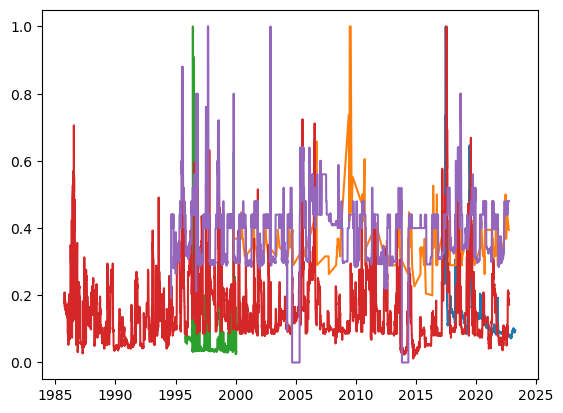

In [32]:
fig,ax = plt.subplots()
for site in np.unique(usgs_df.site)[0:5][0:5]:
    data = usgs_df[usgs_df.site == site]
    ax.plot(data.datetime, data.DISCHARGE/np.nanmax(data.DISCHARGE))
plt.show()

In [81]:

snow_courses = ['Alpha (ALP)', 'Beckwourth (BEA)', 'Big Creek (BIG)', 'Big Flat (BGF)', 'Blue Lakes (BLU)', 'Carson Pass (CSP)', 'Cedar Pass (CED)', 'Chicken Ridge (CHI)', 'Cold Springs (CDS)', 'Cottonwood Lakes (CTN)', 'Cow Creek (COW)', 'Crabtree (CRA)', 'Crater Meadow (CME)', 'Cuyama Peak (CUY)', 'Dismal Swamp (DSW)', 'Donner Summit (DSM)', 'Echo Peak (ECH)', 'Ebbetts Pass (EBB)', 'Echo Lake (ECL)', 'Furnace Creek (FUR)', 'Gem Pass (GEM)', 'Gin Flat (GIN)', 'Horse Meadow (HOR)', 'Independence Creek (IND)', 'Isabella (ISA)', 'Leavitt Lake (LAV)', 'Leavitt Meadow (LVM)', 'Mammoth Pass (MMP)', 'Monitor Pass (MON)', 'Mount Rose (MRS)', 'Onion Valley (ONI)', 'Parker Creek (PAR)', 'Poole Power Plant (POP)', 'Rock Creek (RCK)', 'Rogers Cow Camp (RCC)', 'Rubicon (RUB)', 'Sagehen Creek (SGH)', 'Salmon Creek (SLM)', 'Sherman Pass (SHR)', 'Sierra at Tahoe (SIT)', 'Sonora Pass (SON)', 'Squaw Valley (SQV)', 'Summit Meadow (SUM)', 'Tamarack (TAM)', 'Tioga Pass (TIO)', 'Tuolumne Meadows (TUO)', 'Virginia Lakes Ridge (VIR)']

# Split the snow course names and codes using the first occurrence of "("
name_code_pairs = [(course.split(" (")[0], course.split(" (")[1][0:3]) for course in snow_courses]

# Create a Pandas DataFrame from the name and code pairs
cdec_names = pd.DataFrame(name_code_pairs, columns=["Name", "Code"])


In [82]:
## get all cdec data. doesn't work? maybe with newer version of metloom it will
cdec_ca_data = pd.DataFrame()

for idx, row in cdec_names.iterrows():
    station_id = row.Code
    name = row.Name
    point = CDECPointData(station_id, name)
    df = point.get_snow_course_data(datetime(1950, 9, 30),
                                    datetime(2023, 4, 20),
                                    [ CDECPointData.ALLOWED_VARIABLES.SWE, CDECPointData.ALLOWED_VARIABLES.PRECIPITATION])
    df.reset_index(inplace=True)
    cdec_ca_data = pd.concat([cdec_ca_data, df], ignore_index = True)
    

cdec_ca_data.to_csv(homedir + 'data/cdec_ca_data.csv')

ValueError: ALP is not a snow course

In [83]:
import pandas as pd
import io
import requests

# Define the URL for the CDEC station data
url = "http://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet"
params = {
    "Stations": 'TEST',
    "dur_code": "D",
    "csv": "Yes"
}
cdec_ca_data = pd.DataFrame()

for idx, row in cdec_names.iterrows():
    station_id = row.Code
    name = row.Name
    params['Stations'] = station_id
    response = requests.get(url, params=params)
    if response.status_code == 200:
        df = pd.read_csv(io.StringIO(response.text))
        cdec_ca_data = pd.concat([cdec_ca_data, df], ignore_index = True)
        if len(df) ==0: 
            print('oop')
            break
    else:
        print("Error: Request failed with status code", response.status_code)

cdec_ca_data.to_csv(homedir + 'data/cdec_ca_data.csv')

oop
